# Age and gender prediction

In this project, we will look at the **UTK dataset** from kaggle which has information on **age, gender and ethnicity** of about 24k images. We will use this dataset to train a deep learning model using **Convolutional Neural Networks** to do both a **classification and a regression** task.  **We will train our model to predict age and gender of any given image. The model works with about 88% accuracy on the test set.**

### Loading the data

In [2]:
# unzipping the zipped file
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('/Users/ellietripathi/Python_Projects/Predicting_age_from_a_face/')
files.close()

In [3]:
# importing the dependencies.
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
# Load the datset.
BASE_DIR = '/Users/ellietripathi/Python_Projects/Predicting_age_from_a_face/archive/UTKFace/'

In [5]:
# Creating three labels from the image name: age, gender, ethnicity.
image_paths = []
age_labels = []
gender_labels = []
ethnicity_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    
    # Extract the first three components separated by underscores
    components = filename.split('_')
    if len(components) < 3:
        print(f"Ignoring invalid filename: {filename}")
        continue
    
    try:
        age = int(components[0])
        gender = int(components[1])
        ethnicity = int(components[2])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        ethnicity_labels.append(ethnicity)
    except ValueError:
        print(f"Error processing filename: {filename}")


  0%|          | 0/23708 [00:00<?, ?it/s]

Error processing filename: 39_1_20170116174525125.jpg.chip.jpg
Error processing filename: 61_1_20170109150557335.jpg.chip.jpg
Error processing filename: 61_1_20170109142408075.jpg.chip.jpg


In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['ethnicity'] = image_paths, age_labels, gender_labels, ethnicity_labels
df.head()

,image,age,gender,ethnicity
0,/Users/ellietripathi/Python_Projects/Predictin...,9,1,2
1,/Users/ellietripathi/Python_Projects/Predictin...,36,0,1
2,/Users/ellietripathi/Python_Projects/Predictin...,86,1,0
3,/Users/ellietripathi/Python_Projects/Predictin...,26,1,0
4,/Users/ellietripathi/Python_Projects/Predictin...,1,1,2


In [7]:
# creating a gender dictionary
gender_dict = {0: 'Male', 1: 'Female'}

In [8]:
# checking how many ethnicities there are.
df['ethnicity'].unique()

array([2, 1, 0, 3, 4])

In [9]:
# creating a ethnicity dictionary
ethnicity_dict = {0: 'White', 1: 'Black', 2: 'Asian', 4: 'Indian', 5: 'Hispanic'}

### Exploratory Data Analysis

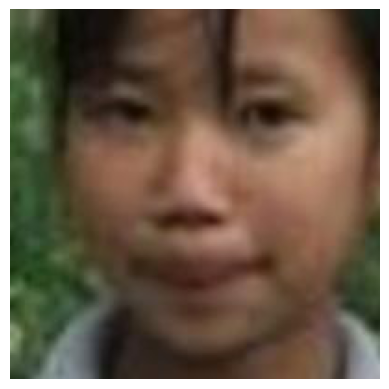

In [10]:
# displaying one image
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

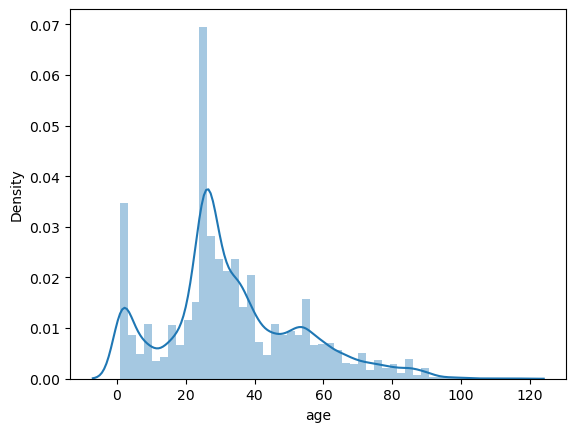

In [11]:
# seeing the class distribution
sns.distplot(df['age'])

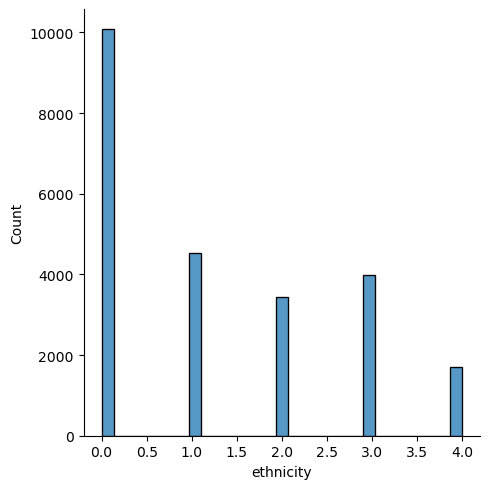

In [12]:
# seeing the ethnicity distribution
sns.displot(df['ethnicity'])

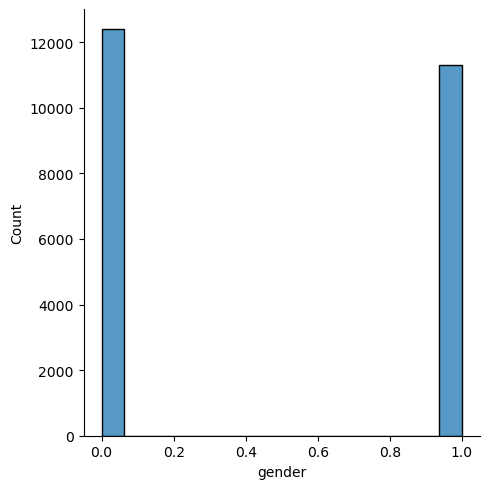

In [13]:
# seeing the gender distribution
sns.displot(df['gender'])

In [14]:
df.isna().sum()

image        0
age          0
gender       0
ethnicity    0
dtype: int64

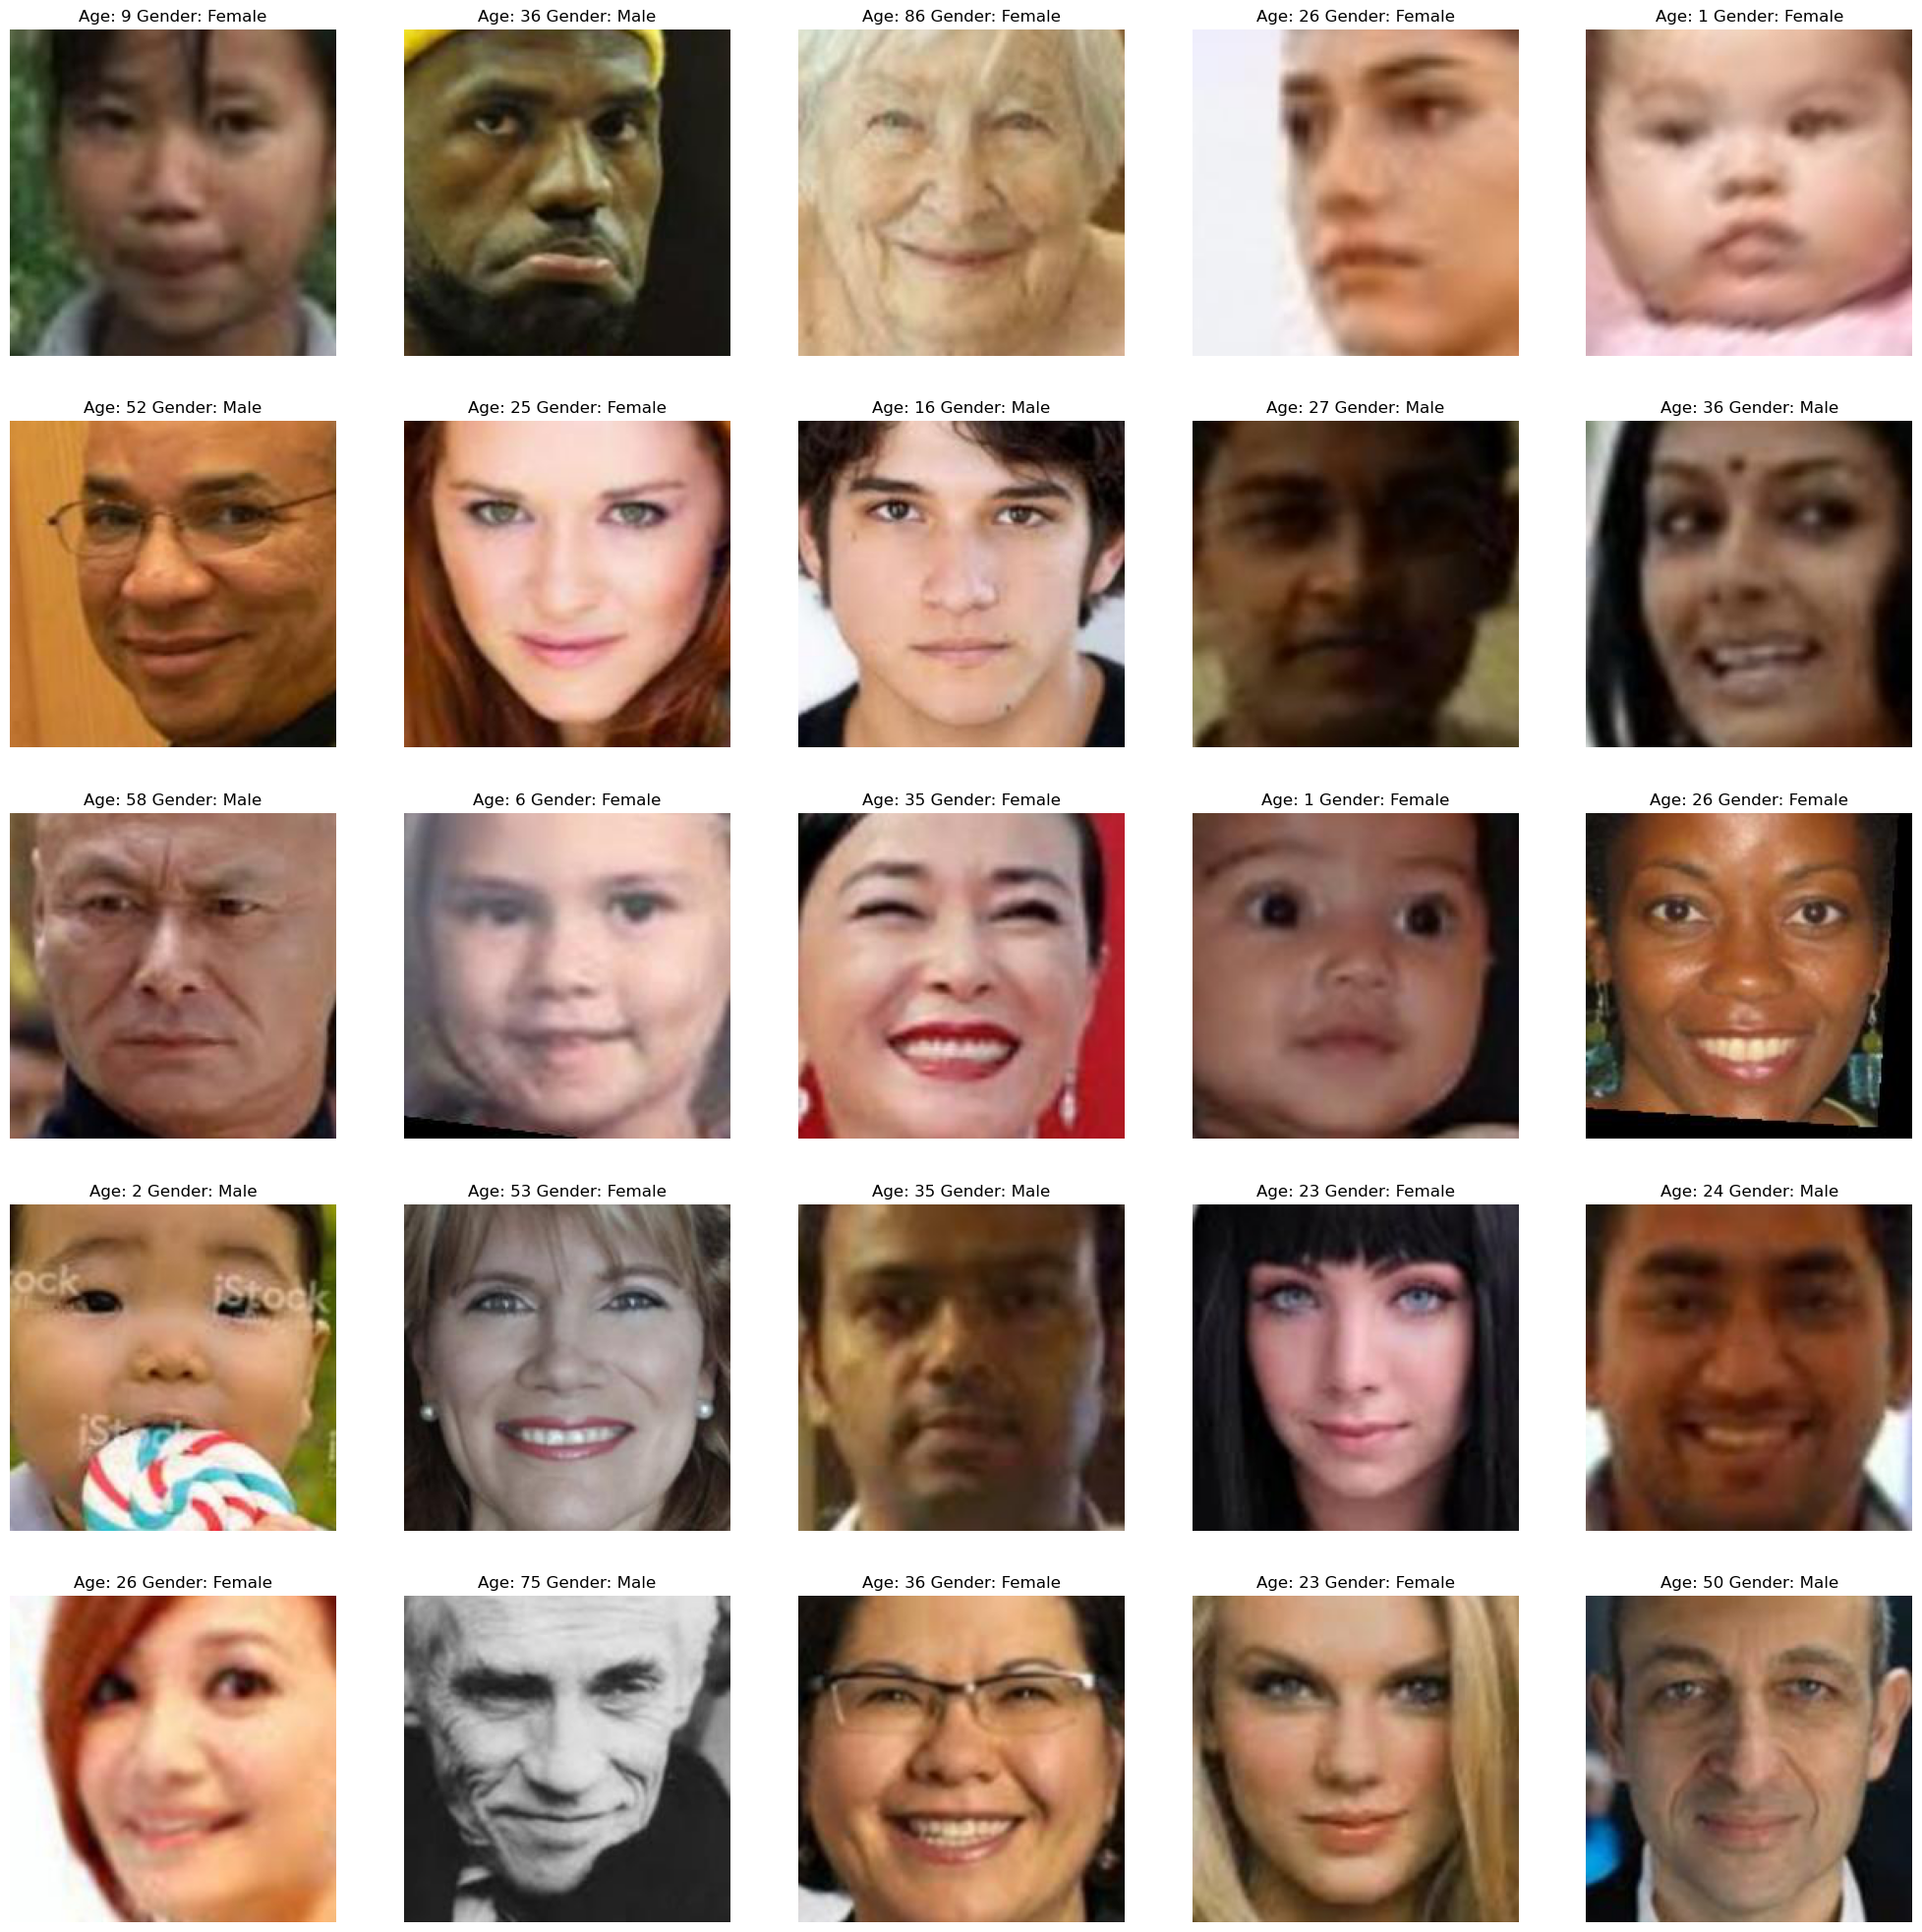

In [16]:
# looking at 25 images to get a sense of the data.
plt.figure(figsize = (25,25))
files = df.iloc[0:25]

for index, file, age, gender, ethnicity in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

### Feature Extraction

In [17]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale = True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [18]:
X = extract_features(df['image'])

  0%|          | 0/23705 [00:00<?, ?it/s]

In [19]:
# shape of X
X.shape

(23705, 128, 128, 1)

In [20]:
# normalize the images.
X = X/255.0

In [21]:
# output variables.
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [22]:
input_shape = (128, 128, 1)

### Model Creation

In [23]:
inputs = Input((input_shape))

# convolutional layers.
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)

# flatteting layer
flatten = Flatten()(maxp_4)

# Dense Layers.
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

# Dropout layers.
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# output layers
output_1 = Dense(1, activation='sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name = 'age_out')(dropout_2)

model = Model(inputs = [inputs], outputs = [output_1, output_2])
model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [25]:
# plot the model.
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
# train the model.
history = model.fit(x = X, y = [y_gender, y_age], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 210s 353ms/step - loss: 10.8689 - gender_out_loss: 0.4631 - age_out_loss: 10.4058 - gender_out_accuracy: 0.7839 - age_out_accuracy: 0.0300 - val_loss: 9.5679 - val_gender_out_loss: 0.4182 - val_age_out_loss: 9.1496 - val_gender_out_accuracy: 0.8043 - val_age_out_accuracy: 0.0240
Epoch 2/10
593/593 [==============================] - 255s 430ms/step - loss: 9.6229 - gender_out_loss: 0.4004 - age_out_loss: 9.2225 - gender_out_accuracy: 0.8178 - age_out_accuracy: 0.0227 - val_loss: 8.6580 - val_gender_out_loss: 0.3631 - val_age_out_loss: 8.2948 - val_gender_out_accuracy: 0.8348 - val_age_out_accuracy: 0.0158
Epoch 3/10
593/593 [==============================] - 221s 372ms/step - loss: 8.5994 - gender_out_loss: 0.3494 - age_out_loss: 8.2501 - gender_out_accuracy: 0.8404 - age_out_accuracy: 0.0206 - val_loss: 8.1319 - val_gender_out_loss: 0.3236 - val_age_out_loss: 7.8084 - val_gender_out_accuracy: 0.8547 - val_age_out_accuracy: 0.0158
Ep

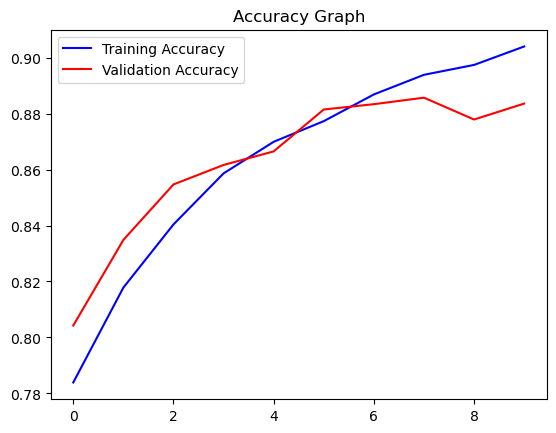

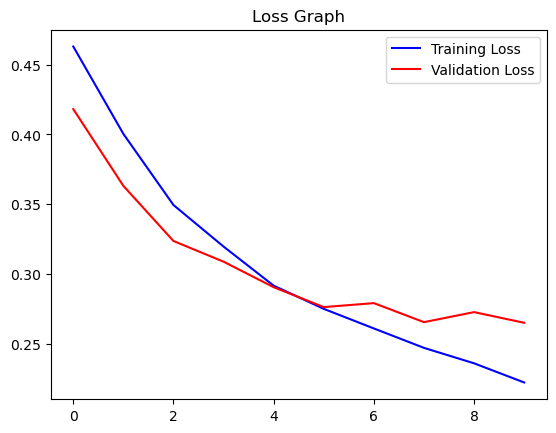

In [30]:
# plot the accuracy and loss graph for gender.
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

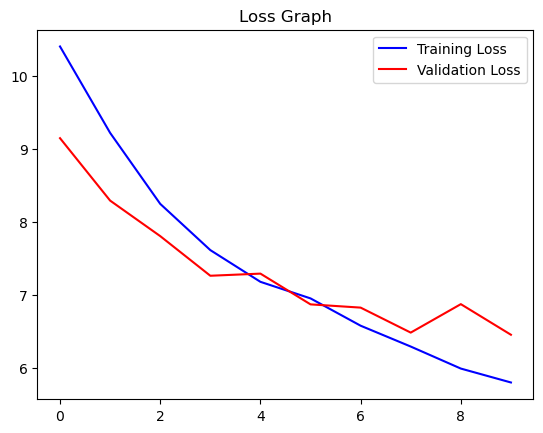

In [31]:
# plot result for age.
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Making a predictive system.

Original Gender: Male Original Age: 32
1/1 [==============================] - 0s 17ms/step
Predicted Gender: Male Predicted Age: 36


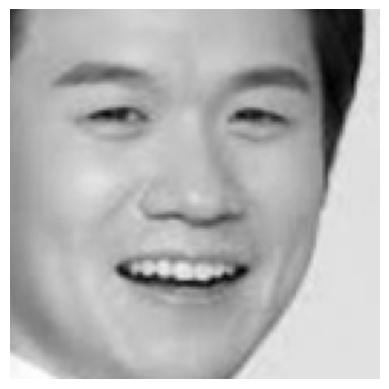

In [42]:
image_index = 3700
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap = 'gray');